# 05: Benchmark LLM bit precision

## 1. Imports

In [1]:
import gc
import copy
# import os
# CACHE_PATH = '<path_to_cache>'
# os.environ["TORCH_HOME"] = CACHE_PATH
# os.environ["HF_HOME"] = CACHE_PATH
# os.environ["HUGGINGFACE_HUB_CACHE"] = CACHE_PATH
# os.environ["HUGGINGFACE_ASSETS_CACHE"] = CACHE_PATH
# os.environ["TRANSFORMERS_CACHE"] = CACHE_PATH

import matplotlib.pyplot as plt
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
# from huggingface_hub import login; login(token="<hf_token>")

import pruna_pro
from pruna_pro import SmashConfig
from pruna_pro import smash
from pruna.data.pruna_datamodule import PrunaDataModule
from pruna.evaluation.evaluation_agent import EvaluationAgent
from pruna.evaluation.metrics.metric_elapsed_time import ElapsedTimeMetric
from pruna.evaluation.metrics.metric_torch import TorchMetricWrapper
from pruna.evaluation.metrics.metric_energy import EnergyMetric
from pruna.evaluation.metrics.metric_memory import GPUMemoryMetric
from pruna.evaluation.metrics.metric_model_architecture import ModelArchitectureMetric
from pruna.evaluation.task import Task

## 2. Utils

The utils functions help for:
- Load from a list of (small) models.  eel free to try other models until the GPU memory is not enough!
- Make plots.
- Iterate over evaluation and model configurations.

In [2]:
model_ids = [
    # "facebook/opt-125m",
    # "facebook/opt-350m", 
    # "facebook/opt-1.3b",
    # "facebook/opt-2.7b",
    # "meta-llama/Llama-3.2-1B",
    # "meta-llama/Llama-3.2-1B-Instruct",
    # "meta-llama/Llama-3.2-3B-Instruct",
    # "google/gemma-3-1b-it",
    # "google/gemma-3-4b-it",
    # "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    # "microsoft/Phi-4-mini-instruct",
    # "HuggingFaceTB/SmolLM-135M",
    # "HuggingFaceTB/SmolLM-135M-instruct",
    # "HuggingFaceTB/SmolLM-360M", 
    # "HuggingFaceTB/SmolLM-360M-Instruct",
    # "HuggingFaceTB/SmolLM-1.7B",
    # "HuggingFaceTB/SmolLM-1.7B-Instruct",
    # "HuggingFaceTB/SmolLM2-135M",
    # "HuggingFaceTB/SmolLM2-135M-Instruct",
    # "HuggingFaceTB/SmolLM2-360M",
    # "HuggingFaceTB/SmolLM2-360M-Instruct", 
    # "HuggingFaceTB/SmolLM2-1.7B",
    # "HuggingFaceTB/SmolLM2-1.7B-Instruct",
    "PleIAs/Pleias-350m-Preview",
    # "PleIAs/Pleias-Pico",
    # "PleIAs/Pleias-1.2b-Preview",
    # "PleIAs/Pleias-Nano",
    # "PleIAs/Pleias-3b-Preview",
]

# Load model and tokenizer for first model in list
model_id = model_ids[0]
model = AutoModelForCausalLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

## 2. Evaluation function for all metrics

In [3]:
def evaluate_model(model, tokenizer, dataset="WikiText"):
    """Evaluate a language model using multiple metrics.

    Args:
        model: The language model to evaluate (AutoModelForCausalLM)
        tokenizer: The tokenizer associated with the model (AutoTokenizer) 
        dataset: Name of the dataset to evaluate on (default: "WikiText")

    Returns:
        dict: Dictionary containing evaluation results with metrics like:
            - Elapsed time (inference speed)
            - GPU memory usage
            - Energy consumption
            - Model architecture details
            - Perplexity score
    """
    metrics = [
        ElapsedTimeMetric(n_iterations = 100,
                          n_warmup_iterations = 10,
                          device = "cuda",
                          timing_type = "sync",),
        GPUMemoryMetric(mode = "disk"),
        EnergyMetric(n_iterations = 100,
                n_warmup_iterations = 10,
                device = "cuda"),
        ModelArchitectureMetric(),
        TorchMetricWrapper(metric_name="perplexity", call_type="y_gt")
            ]

    task = Task(metrics, datamodule=PrunaDataModule.from_string(dataset, tokenizer=tokenizer))
    eval_agent = EvaluationAgent(task)

    # Run evaluation
    return eval_agent.evaluate(model)

In [4]:
def plot_evaluation_results(evaluation_results):
    """
    Plot evaluation metrics for different model configurations.
    
    Args:
        evaluation_results (dict): Dictionary containing evaluation metrics for each model configuration
    """
    # Get metrics from first result (assuming all configs have same metrics)
    first_result = next(iter(evaluation_results.values()))
    metrics = [key for key in first_result.keys() if isinstance(first_result[key], (int, float))]
    data = {}

    for metric in metrics:
        data[metric] = [evaluation_results[model][metric] for model in evaluation_results]

    # Calculate number of rows and columns for subplots
    n_metrics = len(metrics)
    n_cols = 3  # Display 3 plots per row
    n_rows = (n_metrics + n_cols - 1) // n_cols  # Ceiling division to get number of rows needed

    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('Comparison of Models with Different Bit Precision', y=1.02)
    
    # Flatten axes array to make iteration easier
    axes = axes.flatten()

    # Plot each metric
    for idx, (metric, values) in enumerate(data.items()):
        ax = axes[idx]
        ax.bar(list(evaluation_results.keys()), values)
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
    
    # Hide empty subplots if any
    for idx in range(len(metrics), len(axes)):
        axes[idx].set_visible(False)
        
    plt.tight_layout()
    plt.show()


## 3. Benchmark LLMs bit precision

We recommend to checkout the [Pruna documentation](https://pruna.readthedocs.io/en/latest/index.html) for access to AI efficiency functions.


### 3.1 Evaluate quantization configurations

**Implementation task:**
- Apply all the quantization configurations on the base model.
- Evaluate all the quantization configurations on GPU by using the `evaluate_model` function.

In [5]:
def evaluate_configs(model, smash_configs, dataset="WikiText"):
    """Evaluate multiple quantization configurations on a model.

    Args:
        model: The base model to evaluate quantization on (AutoModelForCausalLM)
        smash_configs: List of quantization configurations to evaluate
        dataset: Name of the dataset to evaluate on (default: "WikiText")

    Returns:
        dict: Dictionary mapping quantization bit width to evaluation results, where each result contains:
            - Elapsed time
            - GPU memory usage 
            - Energy consumption
            - Model architecture details
            - Perplexity score
            Returns None for configurations that fail
    """
    results = {}
    
    ### To Complete ###
    for config in smash_configs:
        # Deep copy the model for this config
        model_copy = copy.deepcopy(model)
        
        try:
            # Apply quantization
            quantized_model = smash(model_copy, config)
            
            # Evaluate
            result = evaluate_model(quantized_model, tokenizer, dataset)
            results[config[config['quantizer'] + "_weight_bits"]] = result
            
        except Exception as e:
            print(f"Error evaluating {config['quantizer']}: {str(e)}")
            results[config[config['quantizer'] + "_weight_bits"]] = None

        finally:
            del model_copy
            del quantized_model
            torch.cuda.empty_cache()
            gc.collect()
    ### End of To Complete ###

    return results

### 3.2 Evaluate different bit precision for LLM.int8()

**Implementation task:**
- Define LLM.int8() quantization configurations for all bits that are available.
- Quantize and evalute the base model with all the quantization configurations.
- Plot the results.

**Questions:**
- Which bit precision is the best/worst in terms of quality?
- What is the impact of bit precision on the speed?
- What is the impact of bit precision on the memory?

INFO - Verifying Pruna token.
INFO - You have used 131 hours this month.
INFO - Starting quantizer llm_int8...
`low_cpu_mem_usage` was None, now default to True since model is quantized.
INFO - quantizer llm_int8 was applied successfully.
INFO - You have used 131 hours this month.
INFO - Using call_type: y_gt for metric perplexity
INFO - Using max_seq_len of tokenizer: None
INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7f3faa6f2b00>, tokenizer=PreTrainedTokenizerFast(name_or_path='PleIAs/Pleias-350m-Preview', vocab_size=65536, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|end_of_text|>', 'eos_token': '<|end_of_text|>', 'unk_token': '[UNK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<|begin_of_text|>", rstrip=Fal

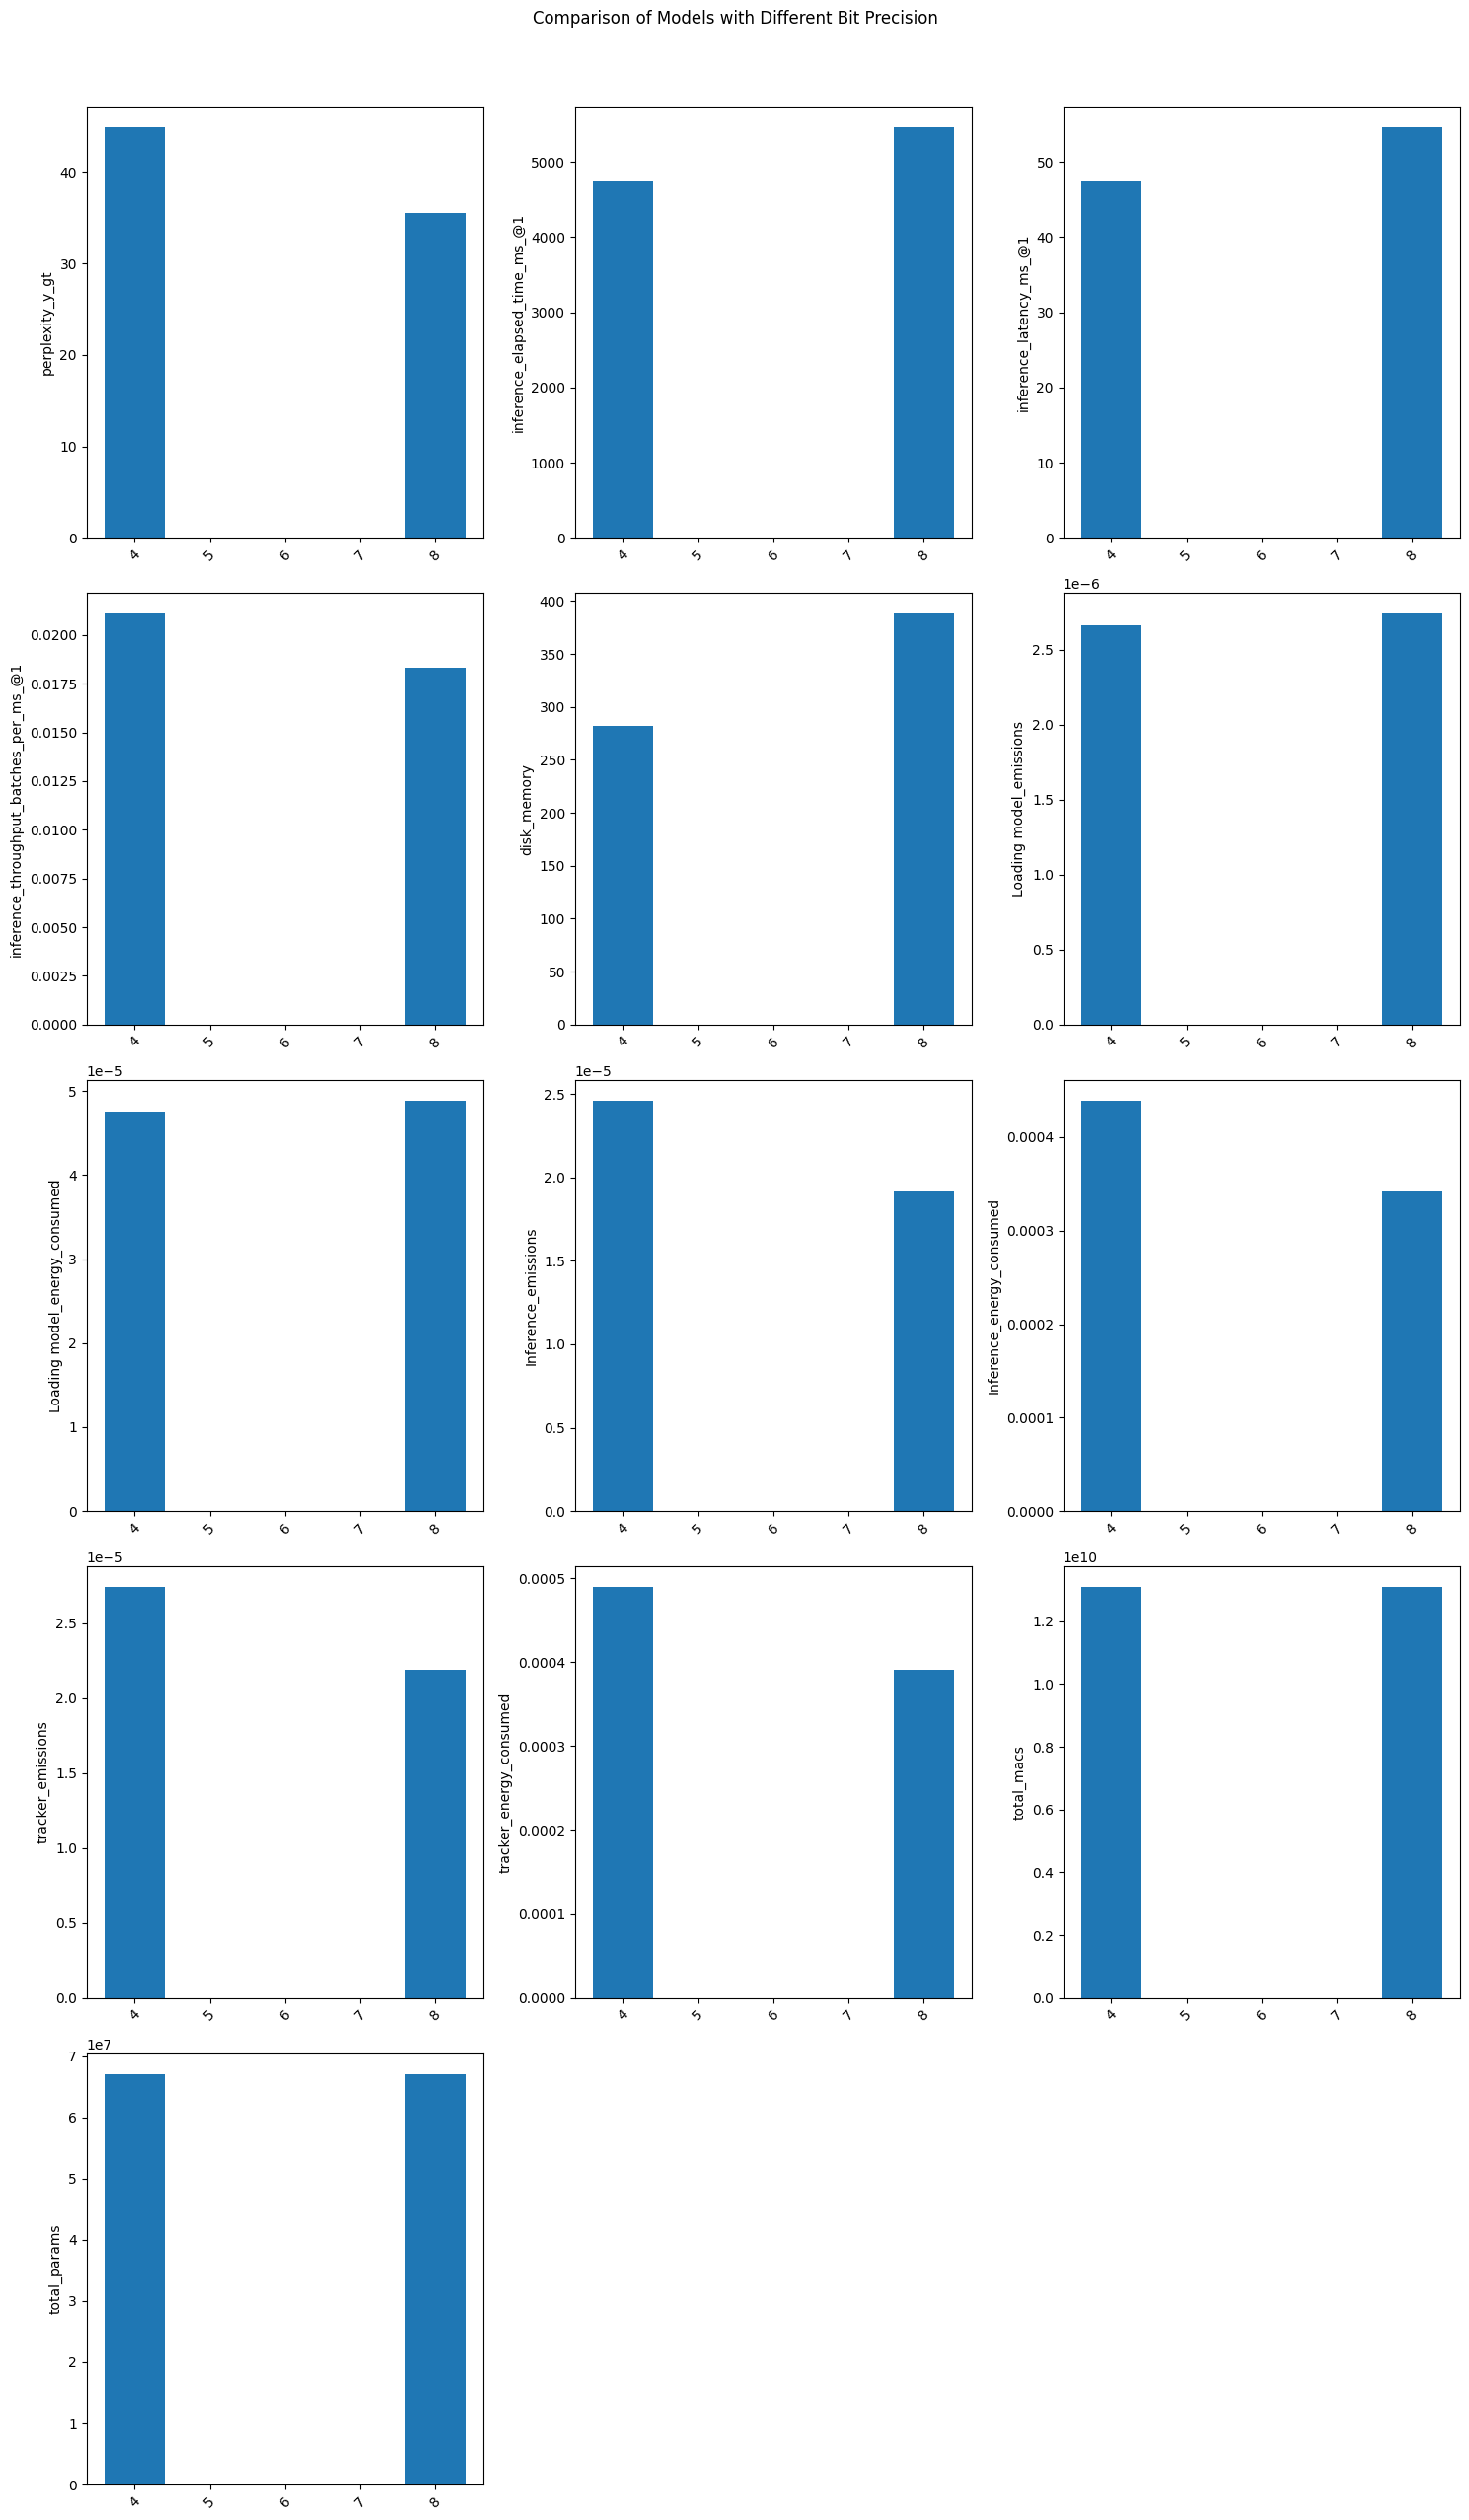

In [6]:
smash_configs = []

### To Complete ###
config_llm_int8 = SmashConfig()
config_llm_int8.add_tokenizer(model_id)
config_llm_int8['quantizer'] = 'llm_int8'
config_llm_int8['llm_int8_weight_bits'] = 8
smash_configs.append(config_llm_int8)

config_llm_int8 = SmashConfig()
config_llm_int8.add_tokenizer(model_id)
config_llm_int8['quantizer'] = 'llm_int8'
config_llm_int8['llm_int8_weight_bits'] = 4
smash_configs.append(config_llm_int8)

# Evaluate all configurations
evaluation_results = evaluate_configs(model, smash_configs)
plot_evaluation_results(evaluation_results)
### End of To Complete ###

### 3.2 Evaluate different bit precision for Quanto

**Implementation task:**
- Define Quanto quantization configurations for all bits that are available.
- Quantize and evalute the base model with all the quantization configurations.
- Plot the results.

**Questions:**
- Which bit precision is the best/worst in terms of quality?
- What is better between qfloat8 and qint8?
- What is the impact of bit precision on the speed?
- What is the impact of bit precision on the memory?

INFO - Verifying Pruna token.
INFO - You have used 131 hours this month.
INFO - Starting quantizer quanto...
ERROR - Calibration requires a tokenizer and dataloader. Skipping calibration.
INFO - quantizer quanto was applied successfully.
INFO - You have used 131 hours this month.
INFO - Using call_type: y_gt for metric perplexity
INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7f3faa6f2b00>, tokenizer=PreTrainedTokenizerFast(name_or_path='PleIAs/Pleias-350m-Preview', vocab_size=65536, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|end_of_text|>', 'eos_token': '<|end_of_text|>', 'unk_token': '[UNK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normaliz

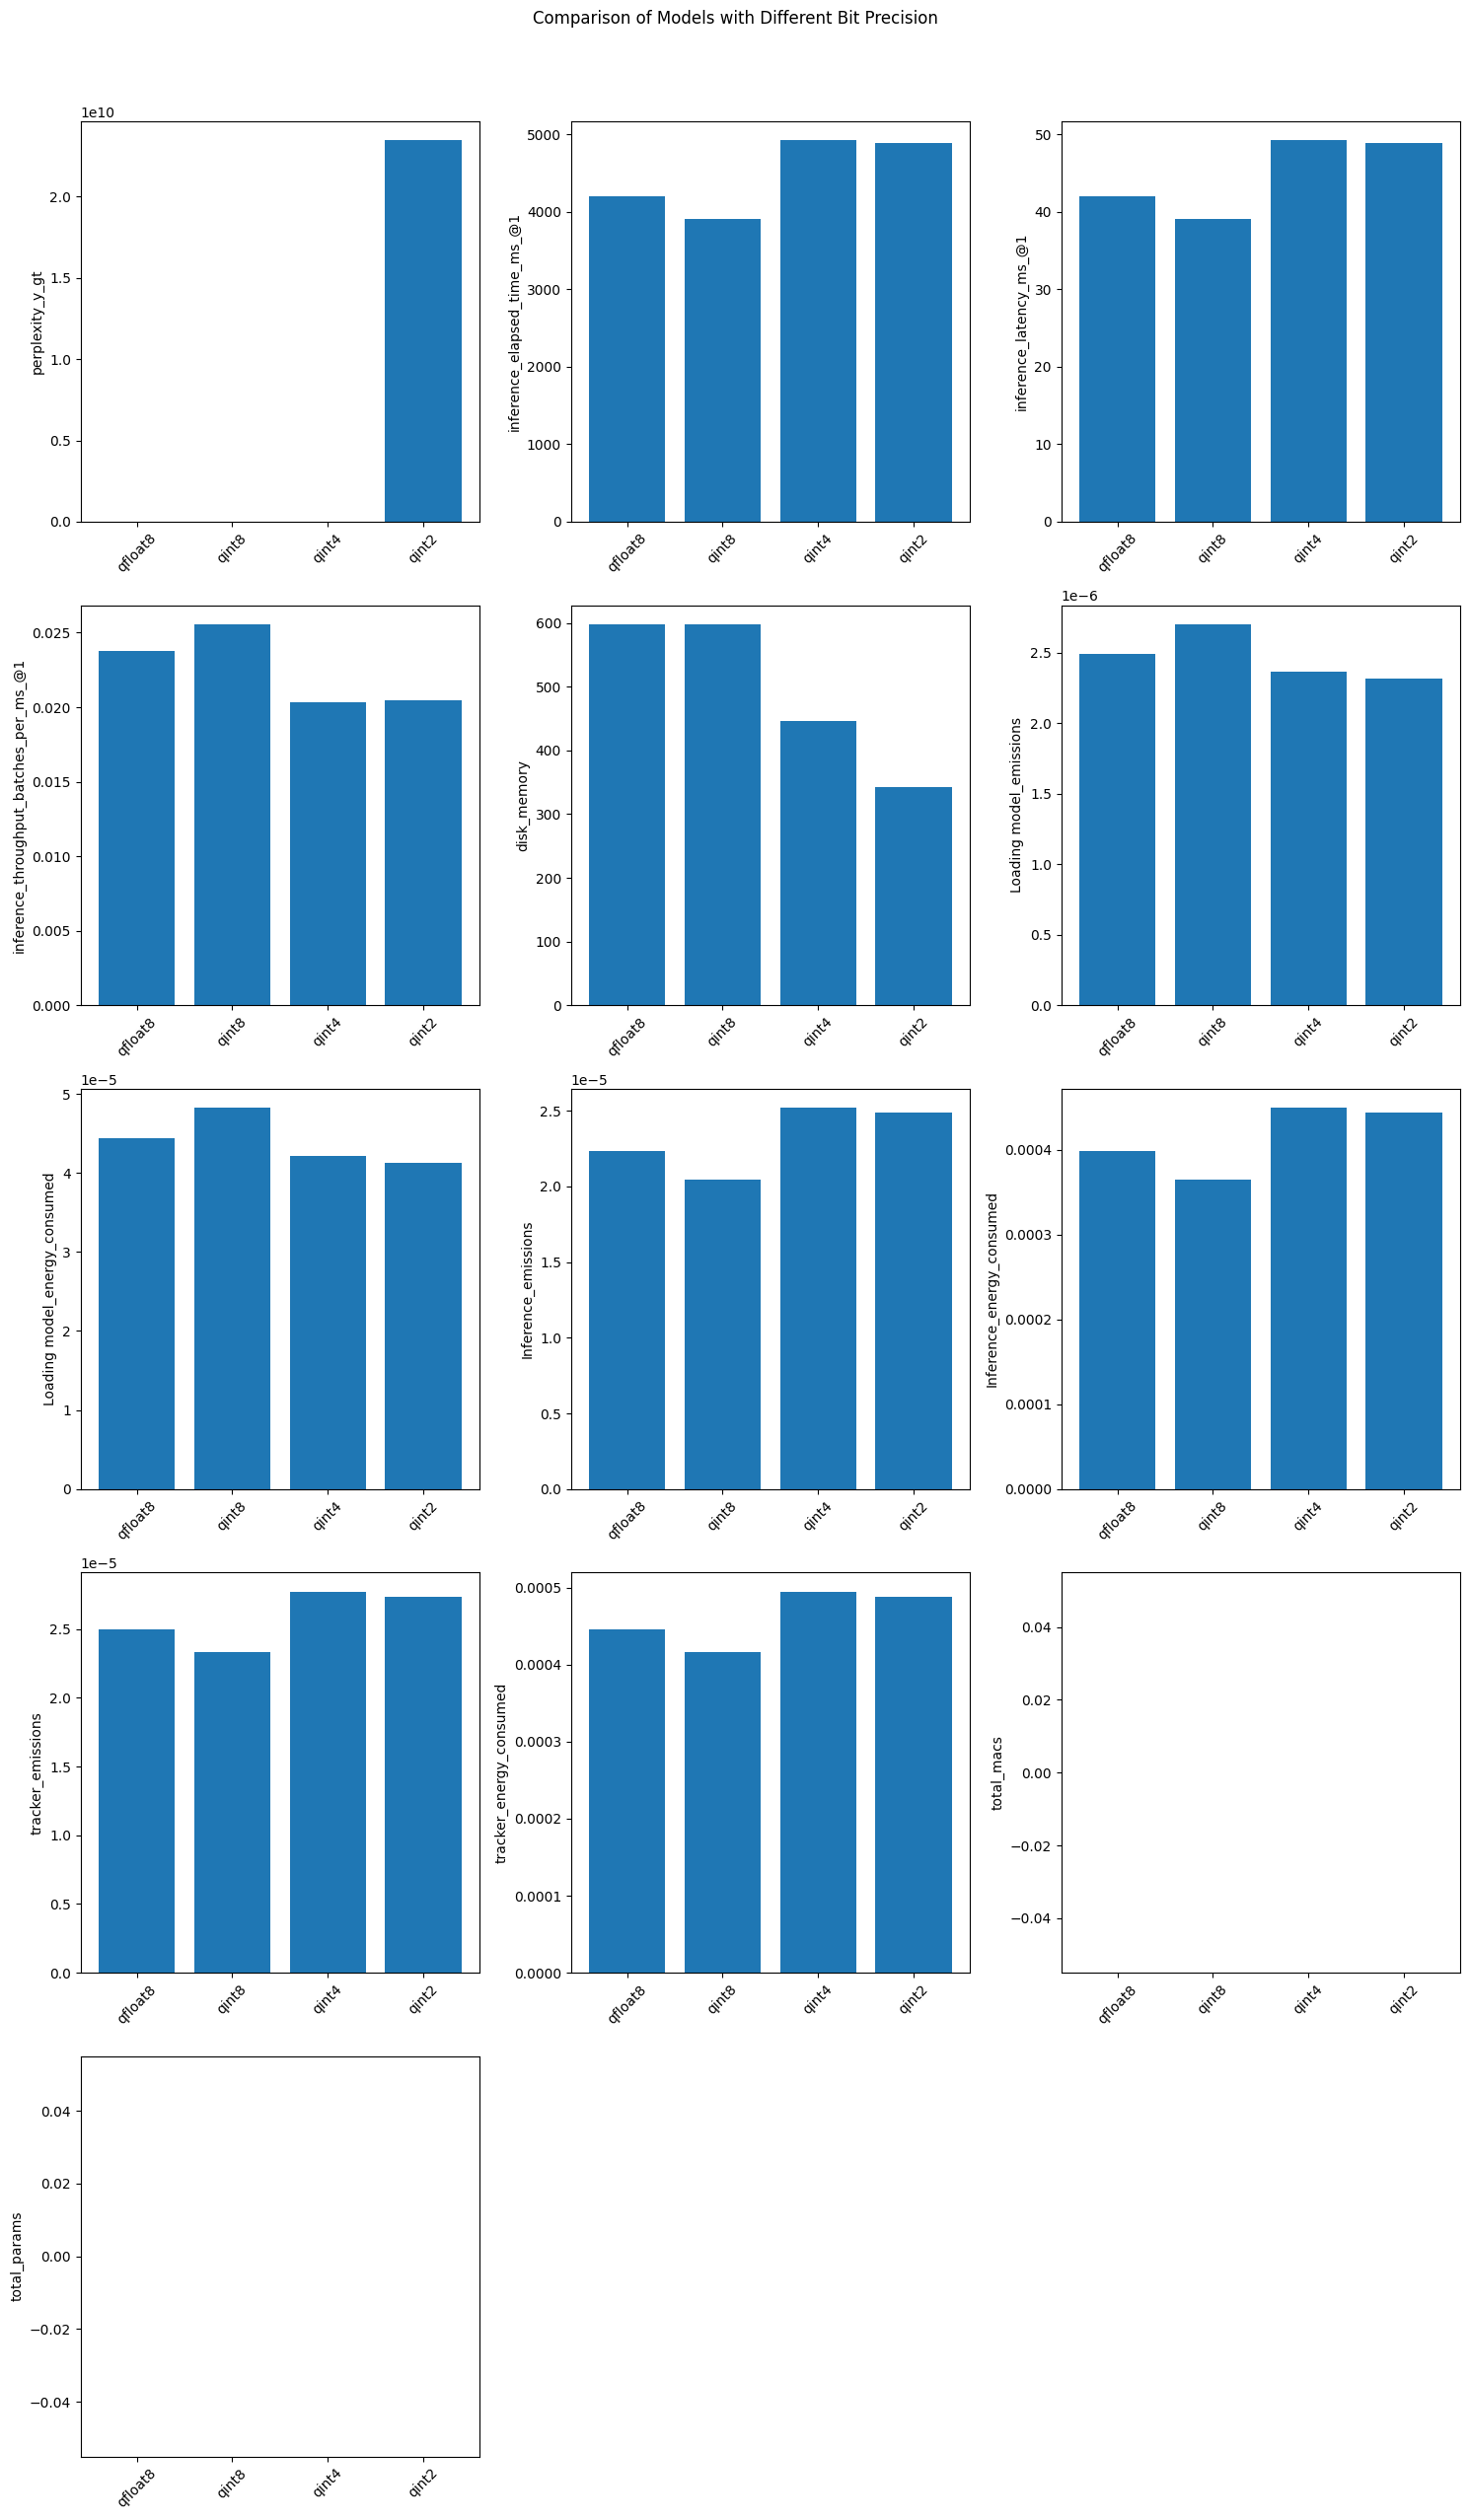

In [7]:
# Create list of SmashConfig with different quantization methods
smash_configs = []

### To Complete ###
config_quanto = SmashConfig()
config_quanto.add_tokenizer(model_id)
config_quanto['quantizer'] = 'quanto'
config_quanto['quanto_weight_bits'] = 'qfloat8'
smash_configs.append(config_quanto)

config_quanto = SmashConfig()
config_quanto.add_tokenizer(model_id)
config_quanto['quantizer'] = 'quanto'
config_quanto['quanto_weight_bits'] = 'qint8'
smash_configs.append(config_quanto)

config_quanto = SmashConfig()
config_quanto.add_tokenizer(model_id)
config_quanto['quantizer'] = 'quanto'
config_quanto['quanto_weight_bits'] = 'qint4'
smash_configs.append(config_quanto)

config_quanto = SmashConfig()
config_quanto.add_tokenizer(model_id)
config_quanto['quantizer'] = 'quanto'
config_quanto['quanto_weight_bits'] = 'qint2'
smash_configs.append(config_quanto)

# Evaluate all configurations
evaluation_results = evaluate_configs(model, smash_configs)
plot_evaluation_results(evaluation_results)
### End of To Complete ###

### 3.3 Evaluate different bit precision for HQQ

**Implementation task:**
- Define HQQ quantization configurations for all bits that are available.
- Quantize and evalute the base model with all the quantization configurations.
- Plot the results.

**Questions:**
- Which bit precision is the best/worst in terms of quality?
- What is the impact of bit precision on the speed?
- What is the impact of bit precision on the memory?
- What would you recommend among all quantization configs that you explored?

INFO - Verifying Pruna token.
INFO - You have used 134 hours this month.
INFO - Starting quantizer hqq...
`low_cpu_mem_usage` was None, now default to True since model is quantized.
ERROR - Error casting model to device: `.to` is not supported for HQQ-quantized models.
ERROR - Error: [Errno 39] Directory not empty: '/usr/users/llmonedgestellantis/pech_esa/.cache/pruna/tmpuldw_u5g/tmpr5smyyje'
100%|█████████████████████████████████████████| 183/183 [00:02<00:00, 71.79it/s]
INFO - quantizer hqq was applied successfully.
INFO - You have used 134 hours this month.
INFO - Using call_type: y_gt for metric perplexity
INFO - Using max_seq_len of tokenizer: None
INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7f03924ba9e0>, tokenizer=PreTrainedTokenizerFast(name_or_path='PleIAs/Pleias-350m-Preview', vocab_size=65536, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token

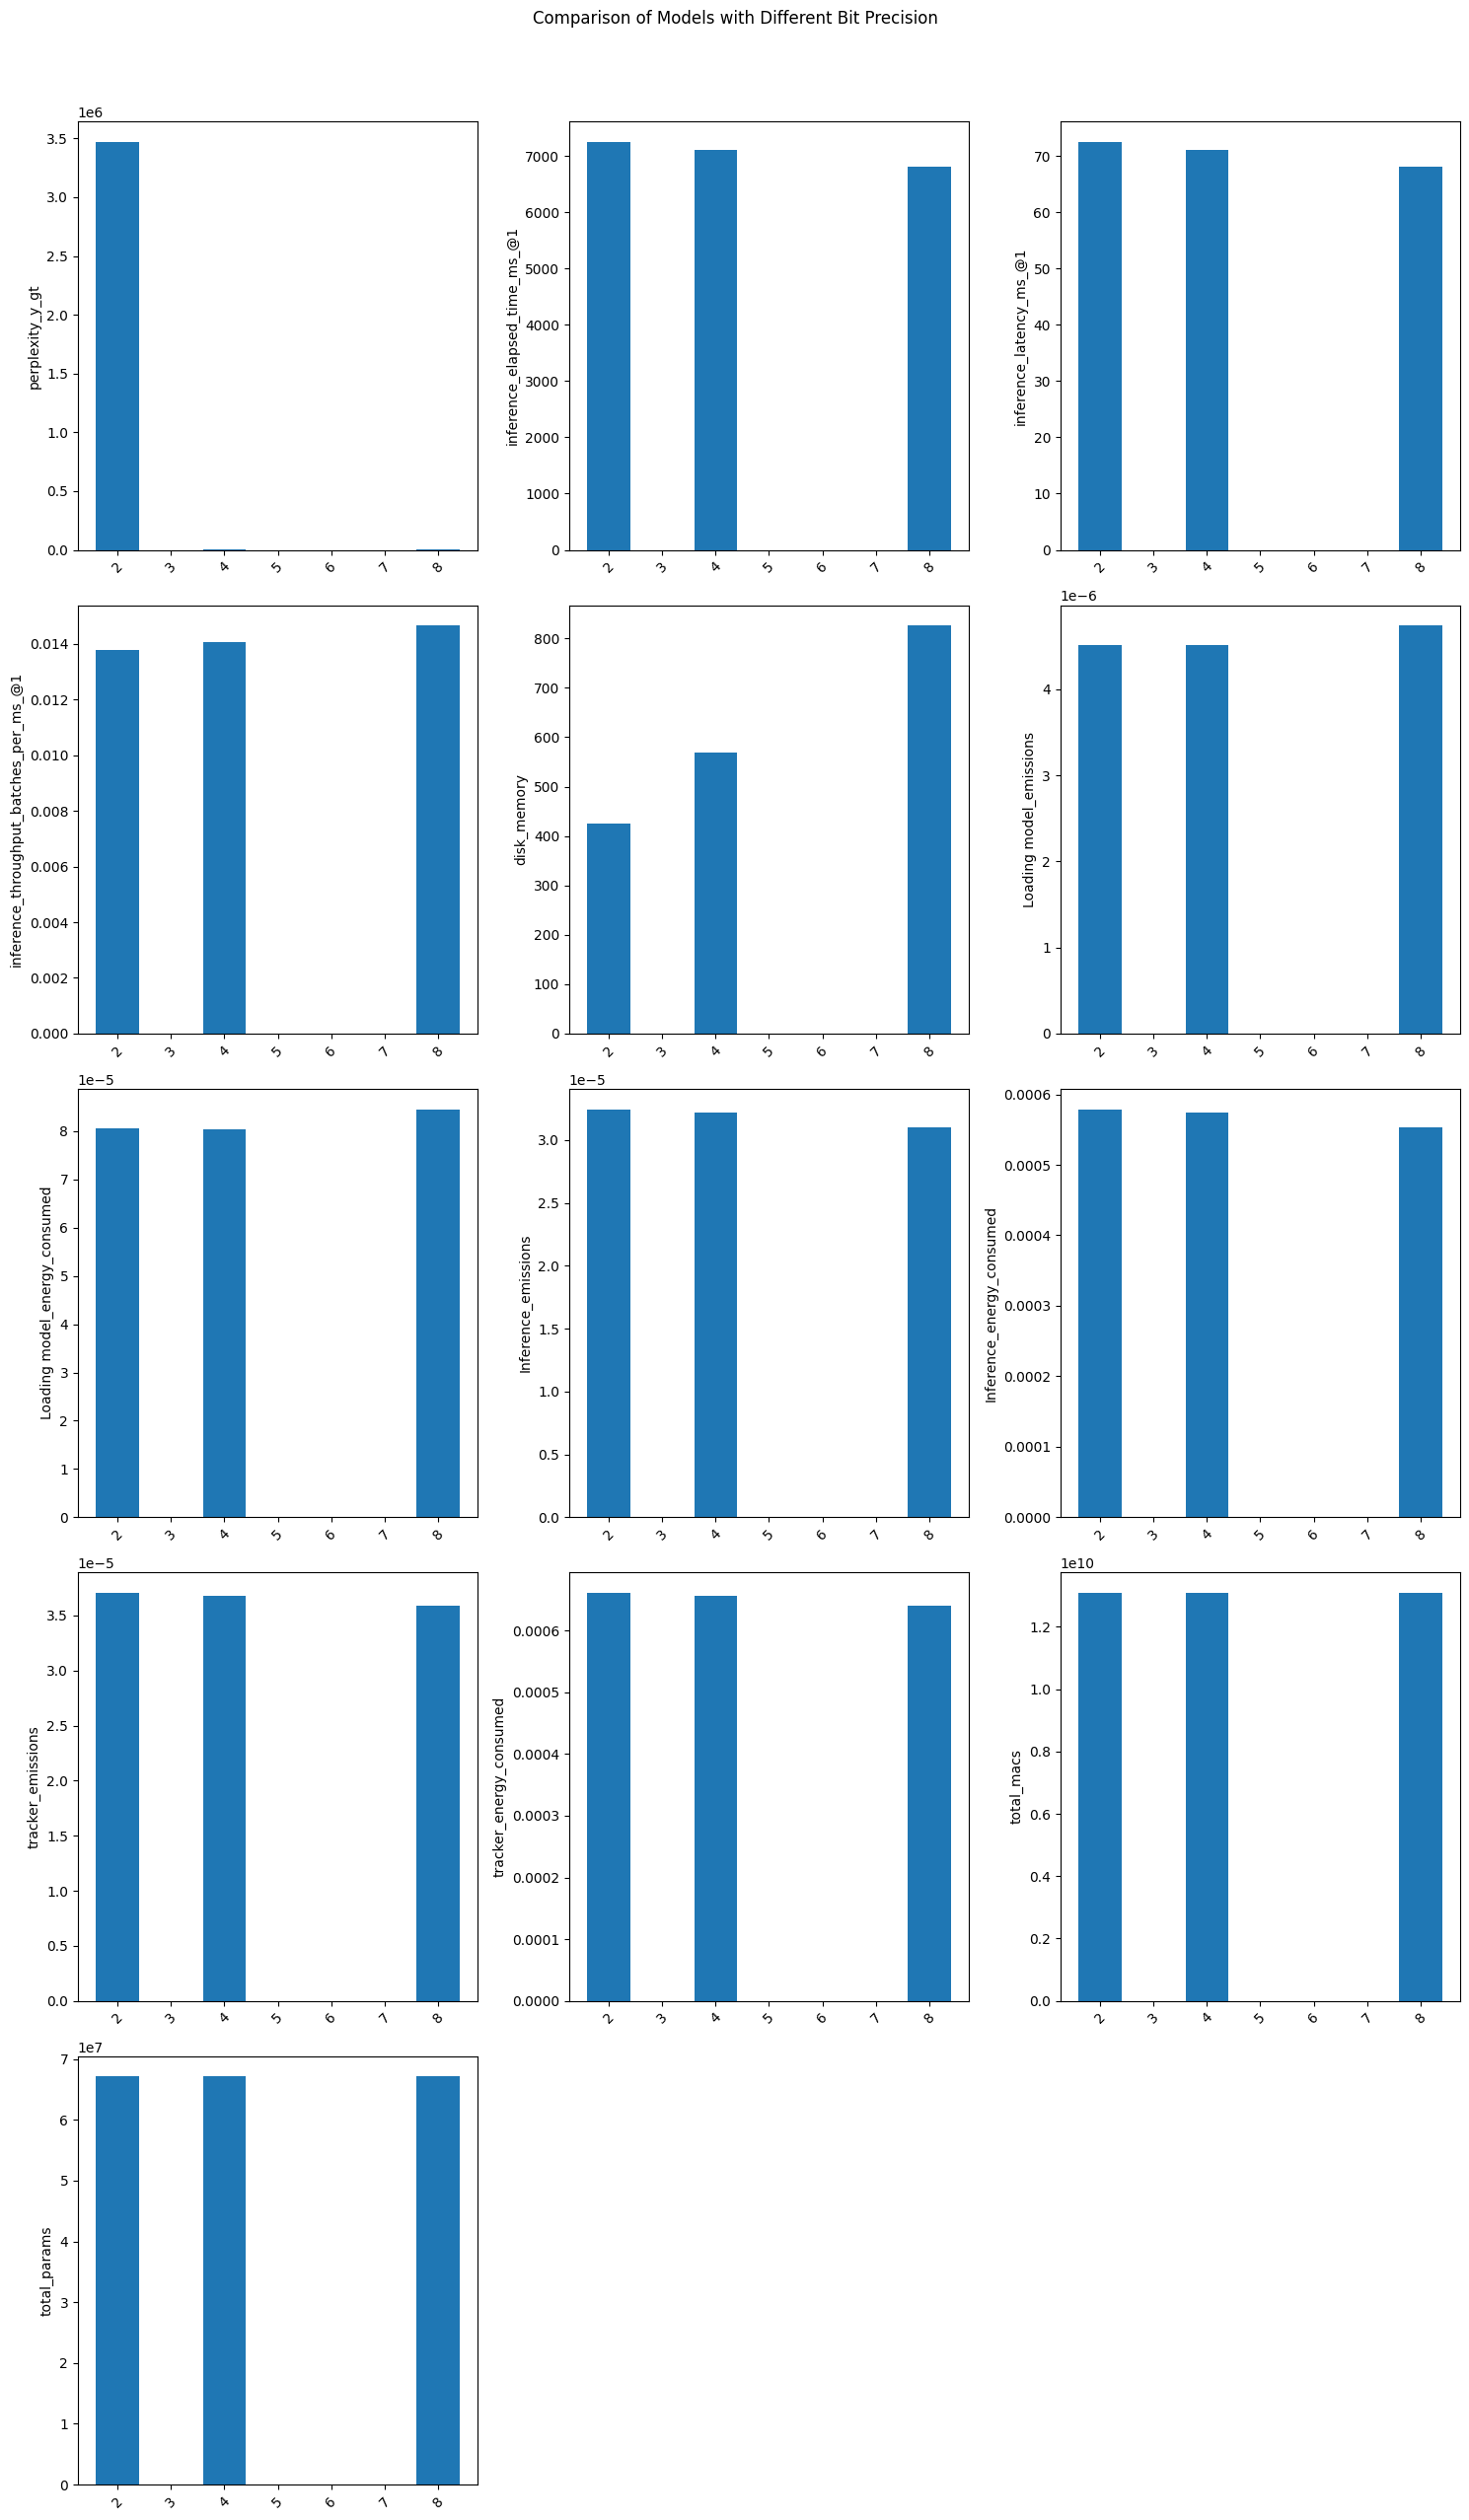

In [8]:
# Create list of SmashConfig with different quantization methods
smash_configs = []

### To Complete ###
config_higgs = SmashConfig()
config_higgs.add_tokenizer(model_id)
config_higgs['quantizer'] = 'hqq'
config_higgs['hqq_weight_bits'] = 8
smash_configs.append(config_higgs)

config_higgs = SmashConfig()
config_higgs.add_tokenizer(model_id)
config_higgs['quantizer'] = 'hqq'
config_higgs['hqq_weight_bits'] = 4
smash_configs.append(config_higgs)

config_higgs = SmashConfig()
config_higgs.add_tokenizer(model_id)
config_higgs['quantizer'] = 'hqq' 
config_higgs['hqq_weight_bits'] = 2
smash_configs.append(config_higgs)

# Evaluate all configurations
evaluation_results = evaluate_configs(model, smash_configs)
plot_evaluation_results(evaluation_results)
### End of To Complete ###